# Weather Prediction

In this project, we want to see if we can use machine learning to predict daily weather conditions (high/low temperature and precipitation) for a location using data from surrounding locations from preceding days.

More specifically, we are going to train a machine-learning model using daily weather data obtained from [Automated Surface Observing System (ASOS)](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/automated-surface-observing-system-asos) units for the 20-year period from 1998 through 2017.  We will use the stations within a 1000-mile radius of Roswell, Georgia, USA (my home town) and try to make predictions for the observations of the closest ASOS unit to that location.

I'm not expecting this to provide very accurate forecasts, but it serves as a simple personal project that will let me exercise the knowledge gained through recent data-science and machine-learning courses.

In [27]:
import ftplib
import gzip
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from geopy import distance

In [28]:
sns.set_style('whitegrid')

%matplotlib inline

## Stations

Our first goal is to get the IDs of all the stations for which we will be processing data.  We want to get a list of all the stations that are within 1000 miles of our location.

In [29]:
# Roswell, GA, USA
my_lat = 34.0232
my_lon = -84.3616

distance_threshold = 1000

date_start = 19980101
date_end = 20171231

First, read the list of all stations available in the ASOS system.

(This data comes from <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv>, but I've stored the file locally.)

In [52]:
stations = pd.read_csv('isd/isd-history.csv',
                       dtype={'USAF'         : str,
                              'WBAN'         : str,
                              'STATION NAME' : str,
                              'CTRY'         : str,
                              'STATE'        : str,
                              'ICAO'         : str,
                              'LAT'          : np.float32,
                              'LON'          : np.float32,
                              'ELEV(M)'      : np.float32,
                              'BEGIN'        : int,
                              'END'          : int})

In [53]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,20140711,20170822
1,007070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,20140923,20150926
2,008403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20140412
3,008411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,20140102,20160217
4,008414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20160217


In [54]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END
count,28767.000000,28766.000000,28673.000000,3.005100e+04,3.005100e+04
mean,30.676743,-3.670850,339.499451,1.978650e+07,2.004861e+07
std,28.731548,87.375031,584.553223,2.365312e+05,1.899937e+05
min,-90.000000,-179.983002,-999.900024,1.901010e+07,1.905123e+07
25%,20.950001,-82.885252,20.000000,1.959010e+07,2.001101e+07
50%,38.909000,5.201000,133.000000,1.977070e+07,2.015072e+07
75%,49.658501,58.917000,424.899994,2.001113e+07,2.018042e+07
max,89.370003,179.750000,7070.000000,2.018040e+07,2.018042e+07


Let's drop any rows that have NaN for LAT or LON.

In [55]:
stations = stations.dropna(subset=['LAT', 'LON'])

We'll only look at the stations for the northern half of the western hemisphere.

In [56]:
stations = stations[(stations['LAT'] > 0.0) & (stations['LON'] < 0.0)]

Let's drop any stations for which data collection began after 1998-01-01 or ended before 2018-01-01.

In [57]:
stations = stations[stations['BEGIN'] <= date_start]
stations = stations[stations['END'] > date_end]

Now determine the distance between each station and my location.

In [58]:
def miles_from_my_location(station):
    my_loc = (my_lat, my_lon)
    station_loc = (station['LAT'], station['LON'])
    return distance.distance(my_loc, station_loc).miles

stations['DISTANCE'] = stations.apply(miles_from_my_location, axis=1)

And now only consider the stations within the 1000-mile radius.

In [59]:
stations = stations[stations['DISTANCE'] <= distance_threshold]

# Allow garbage collection of what we don't need from the original data frame.
stations = stations.copy()

Let's look at what we have.

In [60]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
14482,690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.432999,-99.849998,545.299988,19431201,20180420,902.861945
15640,710630,99999,OTTAWA CDA RCS ONT,CA,NaN,NaN,45.382999,-75.717003,79.000000,19770701,20180419,907.816655
15821,711610,99999,BROCKVILLE CLIMATE,CA,NaN,CTBO,44.632999,-75.733002,120.000000,19930701,20180419,864.541516
15828,711680,99999,SIOUX FALLS CLIMATE,US,SD,NaN,43.733002,-96.633003,481.500000,19941001,20180419,939.499088
15842,711830,99999,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QU,CA,NaN,CWTQ,45.466999,-73.733002,32.000000,19910118,20180419,969.588017


In [61]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
count,486.000000,486.000000,486.000000,4.860000e+02,4.860000e+02,486.000000
mean,37.092964,-84.573616,163.548325,1.966858e+07,2.018042e+07,604.481599
std,6.276627,7.806056,163.556534,1.801366e+05,1.921877e+01,242.103932
min,20.521999,-101.704002,0.000000,1.935100e+07,2.018010e+07,11.541760
25%,32.361250,-90.350000,18.299999,1.946100e+07,2.018042e+07,430.809599
50%,38.347000,-83.546997,126.350002,1.973010e+07,2.018042e+07,628.350925
75%,42.232501,-78.726999,252.549999,1.978794e+07,2.018042e+07,803.484244
max,47.966999,-69.430000,1098.500000,1.997100e+07,2.018042e+07,996.596789


That gives us about 500 stations within the 1000-mile radius. If we plot the locations of these stations and our location, we can see a rough outline of the US East Coast and Gulf Coast, so our set of stations seems to be centered roughly around the southeastern US, as expected.

(-103.32504918298167,
 -67.8089535025652,
 19.138437404304796,
 49.350561008781135)

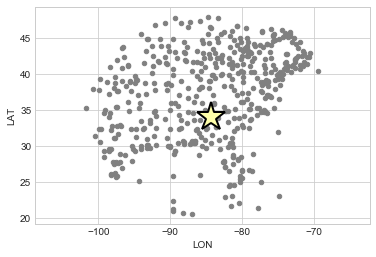

In [62]:
stations.plot.scatter(x='LON', y='LAT', c='gray')
plt.plot(my_lon, my_lat,
         '*', c='#ffffaa', markersize=30,
         markeredgewidth=2, markeredgecolor='black')
plt.axis('equal')

Most of the stations are in the US, but we also have some in Canada, Mexico, the Bahamas, and Cuba.

(The set of all country codes can be downloaded from <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/country-list.txt>.)

In [63]:
stations['CTRY'].unique()

array(['US', 'CA', 'MX', 'BF', 'CU'], dtype=object)

As a quick manual confidence check, let's look at the stations in Georgia.

In [64]:
stations[stations['STATE'] == 'GA']

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
18030,722070,03822,SAVANNAH/HILTON HEAD INTL AIRPORT,US,GA,KSAV,32.131001,-81.202003,14.000000,19480101,20180420,224.941728
18132,722130,13861,WAYCROSS-WARE CO. AIRPORT,US,GA,KAYS,31.250000,-82.400002,43.299999,19421201,20180420,222.696213
18146,722137,13878,MALCOLM MC KINNON AIRPORT,US,GA,KSSI,31.152000,-81.390999,4.900000,19730101,20180420,262.984443
18186,722160,13869,SW GEORGIA REGIONAL ARPT,US,GA,KABY,31.535999,-84.194000,57.900002,19730101,20180420,171.671484
18196,722166,93845,VALDOSTA REGIONAL AIRPORT,US,GA,KVLD,30.783001,-83.277000,60.400002,19480101,20180420,232.092833
18204,722170,03813,MIDDLE GEORGIA REGIONAL AIRPORT,US,GA,KMCN,32.685001,-83.653000,104.599998,19411020,20180420,100.919384
18213,722175,13860,ROBINS AFB AIRPORT,US,GA,KWRB,32.632999,-83.599998,89.599998,19420807,20180420,105.452729
18223,722180,03820,AUGUSTA REGIONAL AT BUSH FIELD AP,US,GA,KAGS,33.363998,-81.962997,40.200001,19480101,20180420,145.457194
18241,722190,13874,HARTSFIELD-JACKSON ATLANTA INTL AP,US,GA,KATL,33.630001,-84.442001,307.899994,19730101,20180420,27.491862
18331,722250,13829,LAWSON AAF AIRPORT,US,GA,KLSF,32.349998,-85.000000,70.699997,19390501,20180420,121.096347


Those distance values look accurate (I checked using the ruler in Google Earth).

We can eyeball this list and see what the closest ASOS unit is, but we'll use Pandas to identify it.'

In [65]:
closest_station = stations.loc[stations['DISTANCE'].idxmin()]

In [66]:
closest_station

USAF                                      722270
WBAN                                       13864
STATION NAME    DOBBINS AIR RESERVE BASE AIRPORT
CTRY                                          US
STATE                                         GA
ICAO                                        KMGE
LAT                                       33.917
LON                                      -84.517
ELEV(M)                                    325.5
BEGIN                                   19460901
END                                     20180420
DISTANCE                                 11.5418
Name: 18352, dtype: object

So, we now have the 486 stations for which we will use data, and we will be trying to make predictions for the weather at [Dobbins ARB (KMGE)](https://en.wikipedia.org/wiki/Dobbins_Air_Reserve_Base).

## Fetching Weather Data for Stations

Next we need to obtain the weather information for each station for the 20-year period.

We will be using the "isd-lite" data, which is described in <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt> and <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-technical-document.txt>, and is available in subdirectories of <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/>.

We need some code to download these files as needed.

In [45]:
def data_file_name(station, year):
    """Return filename for the specified station for the specified year"""
    usaf = station['USAF']
    wban = station['WBAN']
    return f'{usaf}-{wban}-{year}.gz'

def ftp_server_data_path(station, year):
    """Return path to the file on the FTP server for the specified station for the specified year."""
    return f'/pub/data/noaa/isd-lite/{year}/{data_file_name(station, year)}'

def local_data_directory(year):
    """Return local directory for isd-lite data files for the specified year."""
    return f'isd/isd-lite/{year}'
    
def local_data_path(station, year):
    """Return path to local data file for the specified station for the specified year."""
    return f'{local_data_directory(year)}/{data_file_name(station, year)}'
    
def download_data_file(ftp, station, year):
    """Download the specified data file.
    
    Creates the destination directory if necessary.
    
    Returns the path to the downloaded file.
    """
    directory = local_data_directory(year)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    local_path = local_data_path(station, year)
    with open(local_path, 'wb') as f:
        cmd = f'RETR {ftp_server_data_path(station, year)}'
        ftp.retrbinary(cmd, f.write)
    return local_path

def get_downloaded_data_path(station, year):
    """Get path for the specified data file, downloading the file if necessary."""
    local_path = local_data_path(station, year)
    if not os.path.exists(local_path):
        ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
        try:
            ftp.login()
            local_path = download_data_file(ftp, station, year)
        except Exception as e:
            # TODO: If the exception is not "File not found", need to
            # figure out what went wrong.
            print(f'Unable to download {local_path}: {e}')
        finally:
            ftp.quit()
    return local_path

def get_downloaded_station_data_paths(station):
    local_paths = [get_downloaded_data_path(station, year) for year in range(1998, 2019)]
    return local_paths

Each data file is a gzipped text file with the format described in <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt>. We can use Pandas to read it into a data frame.

In [84]:
def read_station_data(path):
    """Read the isd-lite data from the specified path, returning a DataFrame.
    
    The data frame's columns are:
    
    - YEAR
    - MONTH
    - DAY
    - HOUR
    - TEMP (degrees Celsius)
    - DEWPOINT (degrees Celsius)
    - PRESSURE (hectopascals)
    - WIND_DIRECTION (degrees)
    - WIND_SPEED (meters per second)
    - COVERAGE (code)
    - PRECIP_1HR (millimeters)
    - PRECIP_6HR (millimeters)
    
    Values may be NaN, except for YEAR, MONTH, DAY, HOUR
    
    """
    df = pd.read_csv(path, delim_whitespace=True, header=None,
                     names=['YEAR', 'MONTH', 'DAY', 'HOUR',
                            'TEMP', 'DEWPOINT', 'PRESSURE',
                            'WIND_DIRECTION', 'WIND_SPEED',
                            'COVERAGE', 'PRECIP_1HR', 'PRECIP_6HR'],
                     dtype={'YEAR'           : int,
                            'MONTH'          : int,
                            'DAY'            : int,
                            'HOUR'           : int,
                            'TEMP'           : np.float32,
                            'DEWPOINT'       : np.float32,
                            'PRESSURE'       : np.float32,
                            'WIND_DIRECTION' : np.float32,
                            'WIND_SPEED'     : np.float32,
                            'COVERAGE'       : str,
                            'PRECIP_1HR'     : np.float32,
                            'PRECIP_6HR'     : np.float32},
                     na_values='-9999')
    
    # Divide by scaling factors.
    df['TEMP'] = df['TEMP'] / 10.0
    df['DEWPOINT'] = df['DEWPOINT'] / 10.0
    df['PRESSURE'] = df['PRESSURE'] / 10.0
    df['WIND_SPEED'] = df['WIND_SPEED'] / 10.0
    df['PRECIP_1HR'] = df['PRECIP_1HR'] / 10.0
    df['PRECIP_6HR'] = df['PRECIP_6HR'] / 10.0
    
    return df

Let's look at a couple of data files for the closest station.

In [69]:
closest_station_paths = get_downloaded_station_data_paths(closest_station)
print(closest_station_paths)

['isd/isd-lite/1998/722270-13864-1998.gz', 'isd/isd-lite/1999/722270-13864-1999.gz', 'isd/isd-lite/2000/722270-13864-2000.gz', 'isd/isd-lite/2001/722270-13864-2001.gz', 'isd/isd-lite/2002/722270-13864-2002.gz', 'isd/isd-lite/2003/722270-13864-2003.gz', 'isd/isd-lite/2004/722270-13864-2004.gz', 'isd/isd-lite/2005/722270-13864-2005.gz', 'isd/isd-lite/2006/722270-13864-2006.gz', 'isd/isd-lite/2007/722270-13864-2007.gz', 'isd/isd-lite/2008/722270-13864-2008.gz', 'isd/isd-lite/2009/722270-13864-2009.gz', 'isd/isd-lite/2010/722270-13864-2010.gz', 'isd/isd-lite/2011/722270-13864-2011.gz', 'isd/isd-lite/2012/722270-13864-2012.gz', 'isd/isd-lite/2013/722270-13864-2013.gz', 'isd/isd-lite/2014/722270-13864-2014.gz', 'isd/isd-lite/2015/722270-13864-2015.gz', 'isd/isd-lite/2016/722270-13864-2016.gz', 'isd/isd-lite/2017/722270-13864-2017.gz', 'isd/isd-lite/2018/722270-13864-2018.gz']


In [81]:
df_first = read_station_data(closest_station_paths[0])
df_first.head()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,COVERAGE,PRECIP_1HR,PRECIP_6HR
0,1998,1,1,0,1.0,-5.0,1030.099976,320.0,5.1,4,NaN,0.0
1,1998,1,1,1,0.0,-6.0,1030.500000,310.0,4.6,0,NaN,NaN
2,1998,1,1,2,NaN,NaN,1031.400024,330.0,4.6,NaN,NaN,NaN
3,1998,1,1,3,NaN,NaN,1032.199951,330.0,4.1,NaN,NaN,NaN
4,1998,1,1,12,-7.0,-8.0,1035.900024,300.0,1.5,0,NaN,0.0


In [82]:
df_first.describe()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,PRECIP_1HR,PRECIP_6HR
count,6049.0,6049.000000,6049.000000,6049.000000,6043.000000,6043.000000,6034.000000,5682.000000,6048.000000,0.0,1200.000000
mean,1998.0,6.536452,15.763267,13.014052,18.361906,11.112693,1016.636780,210.531509,3.478349,NaN,1.264586
std,0.0,3.421411,8.781811,7.526560,8.935397,8.154440,6.042001,95.958412,1.832725,NaN,4.463020
min,1998.0,1.000000,1.000000,0.000000,-7.000000,-11.000000,993.500000,0.000000,0.000000,NaN,-0.100000
25%,1998.0,4.000000,8.000000,4.000000,11.000000,4.000000,1013.099976,110.000000,2.100000,NaN,0.000000
50%,1998.0,7.000000,16.000000,15.000000,20.000000,12.000000,1016.599976,240.000000,3.100000,NaN,0.000000
75%,1998.0,9.000000,23.000000,19.000000,26.000000,18.000000,1020.500000,290.000000,4.600000,NaN,0.000000
max,1998.0,12.000000,31.000000,23.000000,36.000000,27.000000,1037.199951,360.000000,11.800000,NaN,52.799999


In [86]:
df_last = read_station_data(closest_station_paths[-1])
df_last.tail()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,COVERAGE,PRECIP_1HR,PRECIP_6HR
2641,2018,4,22,1,18.000000,5.2,1023.900024,110.0,3.6,NaN,NaN,NaN
2642,2018,4,22,2,17.100000,5.4,1024.500000,90.0,3.6,NaN,NaN,NaN
2643,2018,4,22,3,16.700001,5.6,1024.099976,90.0,2.1,NaN,NaN,NaN
2644,2018,4,22,4,15.700000,5.3,1023.700012,90.0,3.1,NaN,NaN,NaN
2645,2018,4,22,5,16.000000,5.0,1024.000000,110.0,3.1,NaN,NaN,NaN


In [87]:
df_last.describe()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,PRECIP_1HR,PRECIP_6HR
count,2646.0,2646.000000,2646.000000,2646.000000,2634.000000,2634.000000,2554.000000,2645.000000,2646.000000,400.000000,124.000000
mean,2018.0,2.373016,14.716175,11.475435,9.976304,2.411161,1021.235046,185.546310,3.457594,0.952747,3.322578
std,0.0,1.082396,8.485055,6.937417,7.837881,9.275095,6.975954,112.732895,2.287164,2.624103,6.487331
min,2018.0,1.000000,1.000000,0.000000,-11.300000,-21.200001,999.200012,0.000000,0.000000,-0.100000,-0.100000
25%,2018.0,1.000000,7.000000,5.000000,4.525000,-4.500000,1016.400024,90.000000,2.100000,-0.100000,-0.100000
50%,2018.0,2.000000,14.000000,11.000000,10.800000,3.200000,1021.299988,200.000000,3.100000,0.200000,0.500000
75%,2018.0,3.000000,21.000000,17.000000,15.500000,10.600000,1026.400024,300.000000,5.100000,0.850000,3.300000
max,2018.0,4.000000,31.000000,23.000000,28.400000,19.299999,1037.199951,360.000000,11.300000,36.099998,37.099998


## High Temperature Prediction

We'll start by training a model to predict the high temperature for `closest_station` given the previous day's high, low, and precipitation values for all stations.  Then we can extend this to use the previous _N_ days of data.

### Training

In [48]:
# TODO

### Evaluation

In [49]:
# TODO

## Low Temperature Prediction

In [50]:
# TODO

## Precipitation Prediction

In [51]:
# TODO